## Introduction to the Problem

In the high-stakes world of battle royale games like PlayerUnknown's Battlegrounds (PUBG), every match is a new story. While winning is the ultimate goal, a player's experience is defined by more than just their final rank. A player who gets ten kills but is eliminated early due to bad luck has a vastly different—and likely more frustrating—experience than a player who hides and survives to the end with zero kills.

This project tackles that nuanced problem. Instead of predicting long-term churn, we aim to identify **in-match frustration**.

**The central question is: Can we use a player's in-match actions (kills, damage, distance traveled) to predict their expected final placement, and then use the *error* in that prediction to quantify how frustrating their match was?**

By answering this, we can create a "Frustration Score" to identify players who are performing well but not being rewarded. This could be used by game developers to fine-tune game balance or even by players themselves to understand their own performance beyond the final scoreboard.

In [1]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

In [2]:
random_state = 42

## The Dataset

To answer our question, we are using the rich and authentic dataset from the **PUBG Finish Placement Prediction** competition on Kaggle. This dataset contains detailed statistics from over 4 million individual player performances in PUBG matches.

This project uses data from the [PUBG Finish Placement Prediction](https://www.kaggle.com/c/pubg-finish-placement-prediction/data) competition on Kaggle.

To run this notebook, please download the `train_V2.csv` file from the link above and place it in the root directory of this project.

**Note:** The data file is not included in this repository due to its large size and to respect the data source's distribution policy.

**Target Variable** Our primary goal is to predict a player's final placement. Therefore, our target variable ($y$) is:
* **`winPlacePerc`**: A continuous value from **0.0** (finished last) to **1.0** (won the match). It represents the player's rank as a percentile, providing a standardized measure of success across matches with different numbers of players.

**Features** 
From the many columns available, we will select a core set of features that best represent a player's skill, effort, and strategy during a match.

| Feature Name | Description | Data Type | Type |
| :--- | :--- | :--- | :--- |
| **`kills`** | Number of enemy players killed. | Numerical | Original |
| **`assists`** | Number of times a player assisted a teammate in a kill. | Numerical | Original |
| **`DBNOs`** | Number of times a player knocked down an enemy ("Down But Not Out"). | Numerical | Original |
| **`damageDealt`** | Total damage inflicted on opponents. | Numerical | Original |
| **`headshotKills`** | Number of kills that were headshots. | Numerical | Original |
| **`killStreaks`** | The player's longest kill streak in the match. | Numerical | Original |
| **`longestKill`** | The distance of the player's longest kill. | Numerical | Original |
| **`walkDistance`** | Total distance traveled on foot. | Numerical | Original |
| **`rideDistance`** | Total distance traveled in a vehicle. | Numerical | Original |
| **`swimDistance`** | Total distance traveled by swimming. | Numerical | Original |
| **`revives`** | Number of times a player revived a teammate. | Numerical | Original |
| **`heals`** | Number of healing items used. | Numerical | Original |
| **`boosts`** | Number of boosting items used. | Numerical | Original |
| **`weaponsAcquired`** | Number of weapons picked up. | Numerical | Original |
| **`teamKills`** | Number of times a player killed a teammate. | Numerical | Original |
| **`matchType`** | The type of match (e.g., 'squad-fpp', 'duo', 'solo'). | Categorical | Original |
| **`totalDistance`** | The sum of all travel distances (walk, ride, swim). | Numerical | Engineered |
| **`headshotRate`** | The percentage of a player's kills that were headshots. | Numerical | Engineered |
| **`itemsUsed`** | The combined total of healing and boosting items used. | Numerical | Engineered |
| **`Id`, `groupId`, `matchId`** | Unique identifiers for player, group, and match. | Categorical | Original |
| **`killPlace`** | Player's in-match rank based on number of kills. | Numerical | Original |
| **`killPoints`, `rankPoints`, `winPoints`** | Deprecated ranking points from the game's old system. | Numerical | Original |

In [3]:
# IMPORTANT NOTE: Our dataset contains more that 4 million rows
# so it may take a while to load it
# to speed loading times, analysts may consider using a sample of the dataset only
df = pd.read_csv('train_V2.csv')
df.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,...,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,...,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,...,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875


## Initial Data Pre-Processing and Feature Engineering

The PUBG dataset is massive and contains some quirks that need to be addressed before we can begin our analysis. Our pre-processing will focus on cleaning the data and then engineering the features we designed to capture nuanced player strategies.

### Initial Cleaning

First, we simplify our dataset by removing columns that are either irrelevant for prediction or could introduce problems like data leakage. Our goal is to create a model based purely on **in-game actions**, not demographics or pre-calculated labels.

We will **drop** the following columns:
- **`Id`, `groupId`, `matchId`**: these are just identifiers with no meaningful information
- **`killPlace`**: too close to our target variable, which can lead to data leakage.
- **`killPoints`, `rankPoints`,  `winPoints`**: these are part of a deprecated ranking system so they can be misleading

In [4]:
df = df.drop(columns=['Id', 'groupId', 'matchId', 'killPlace', 'killPoints', 'rankPoints', 'winPoints'])
df.head()

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,kills,killStreaks,longestKill,matchDuration,...,numGroups,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPlacePerc
0,0,0,0.00,0,0,0,0,0,0.00,1306,...,26,0,0.0000,0,0.00,0,0,244.80,1,0.4444
1,0,0,91.47,0,0,0,0,0,0.00,1777,...,25,0,0.0045,0,11.04,0,0,1434.00,5,0.6400
2,1,0,68.00,0,0,0,0,0,0.00,1318,...,47,0,0.0000,0,0.00,0,0,161.80,2,0.7755
3,0,0,32.90,0,0,0,0,0,0.00,1436,...,30,0,0.0000,0,0.00,0,0,202.70,3,0.1667
4,0,0,100.00,0,0,0,1,1,58.53,1424,...,95,0,0.0000,0,0.00,0,0,49.75,2,0.1875


Next, we will check for any missing data that may impact our model, and decide on a strategy to handle them.

In [5]:
df.isnull().sum()

assists            0
boosts             0
damageDealt        0
DBNOs              0
headshotKills      0
heals              0
kills              0
killStreaks        0
longestKill        0
matchDuration      0
matchType          0
maxPlace           0
numGroups          0
revives            0
rideDistance       0
roadKills          0
swimDistance       0
teamKills          0
vehicleDestroys    0
walkDistance       0
weaponsAcquired    0
winPlacePerc       1
dtype: int64

In [6]:
# If the target is missing, we can't use that row for training or validation
df = df.dropna(subset=['winPlacePerc'])
df = df.reset_index(drop=True)

### Encoding Categorical Features

The `matchType` column contains valuable information about the game mode. Since there is no inherent order to modes like 'solo' vs 'squad', we will use one-hot encoding to convert this feature into a numerical format the model can understand.

In [7]:
onehot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
df_matchtype_encoded = onehot_encoder.fit_transform(df[['matchType']])
df = df.drop(columns=['matchType'])
df = pd.concat([df, pd.DataFrame(df_matchtype_encoded, columns=onehot_encoder.get_feature_names_out(['matchType']))], axis=1)

df.head()

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,kills,killStreaks,longestKill,matchDuration,...,matchType_normal-duo,matchType_normal-duo-fpp,matchType_normal-solo,matchType_normal-solo-fpp,matchType_normal-squad,matchType_normal-squad-fpp,matchType_solo,matchType_solo-fpp,matchType_squad,matchType_squad-fpp
0,0,0,0.00,0,0,0,0,0,0.00,1306,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0,0,91.47,0,0,0,0,0,0.00,1777,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1,0,68.00,0,0,0,0,0,0.00,1318,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,32.90,0,0,0,0,0,0.00,1436,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0,0,100.00,0,0,0,1,1,58.53,1424,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


### Engineering New Features

Now, we'll craft new features to capture complex player behaviors that aren't represented by a single column.

1.  **`totalDistance`**: A single metric for a player's overall movement and map engagement.

      * **Formula**: `walkDistance + rideDistance + swimDistance`

2.  **`headshotRate`**: Measures a player's **precision and skill**. A high rate is a strong indicator of a skilled player.

      * **Formula**: `headshotKills / kills` (We'll need to handle cases where `kills` is 0 to avoid division errors).

3.  **`itemsUsed`**: A combined score for a player's resource management and focus on survival.

      * **Formula**: `heals + boosts`

In [8]:
df['totalDistance'] = df['walkDistance'] + df['rideDistance'] + df['swimDistance']
df['headshotRate'] = df['headshotKills'] / df['kills']
df['headshotRate'] = df['headshotRate'].fillna(0)  # If kills = 0, headshotRate is 0
df['itemsUsed'] = df['heals'] + df['boosts']

df[['totalDistance', 'headshotRate', 'itemsUsed']].head()

,totalDistance,headshotRate,itemsUsed
0,244.8000,0.0,0
1,1445.0445,0.0,0
2,161.8000,0.0,0
3,202.7000,0.0,0
4,49.7500,0.0,0


Finally, let's separate our features and our target variable before we proceed with understanding our data. 

In [9]:
df_features = df.drop(columns=['winPlacePerc'])
df_features = df_features.reindex(sorted(df_features.columns), axis=1) # Sort columns for easier viewing
df_target = df['winPlacePerc']

## Exploratory Data Analysis (EDA)

With our data pre-processed, we can now explore the relationships between our features and the target, `PlayerLevel`.

### Checking for Multicollinearity

First, we'll use a heatmap to check if any of our predictor variables are highly correlated with each other. This is crucial for linear models.

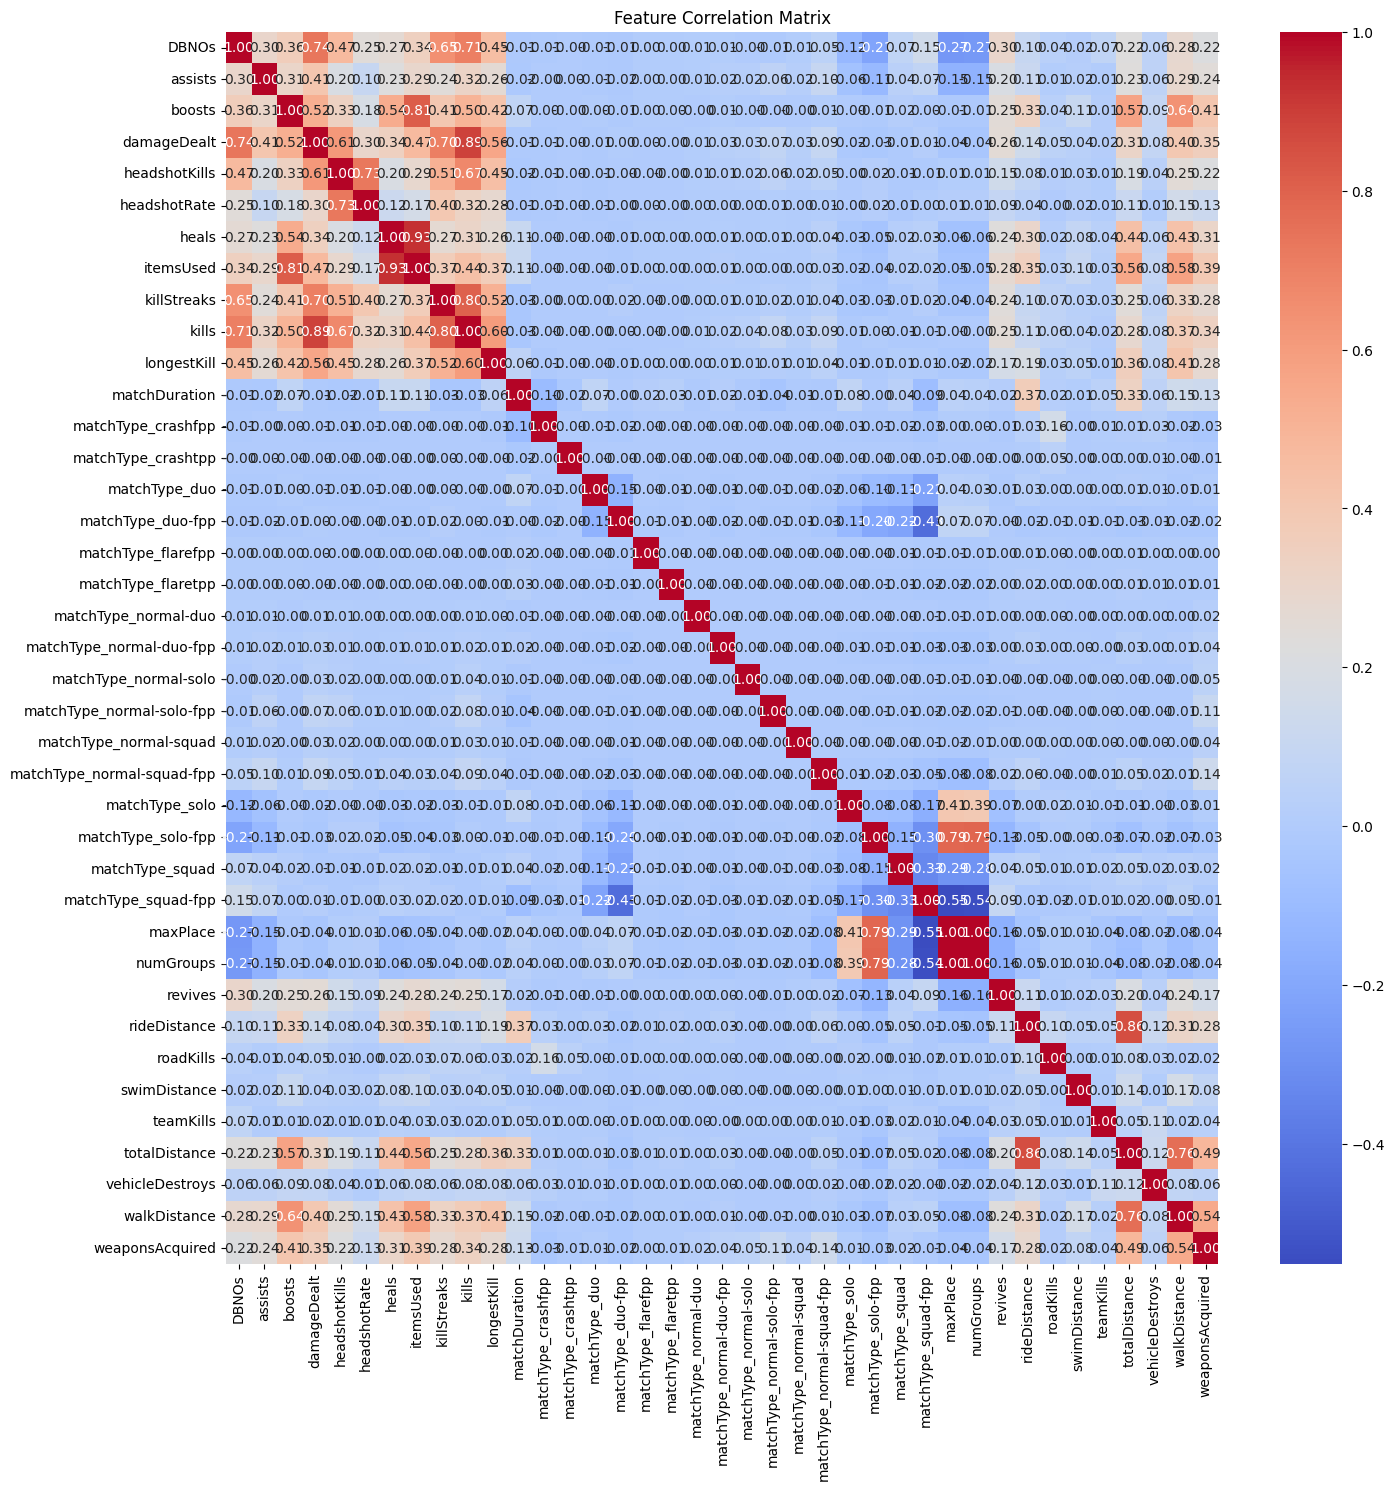

In [10]:
corr = df_features.corr()

plt.figure(figsize=(16, 16))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

The heatmap reveals several strong correlations, which is expected given a massive number of features. Most importantly, our engineered features share strong correlations with their parent features. This is also expected. 

Highly correlated features leads to a problem called multicollinearity, where the model becomes unstable and sensitive to small changes in either of these correlated features. This can be combated by only keeping one of the correlated features, and removing the other. 

To avoid multicollinearity, we will proceed with the more powerful engineered feature and exclude its parents from our model. Future analysts who choose to experiment are encouraged to alter with `columns_to_remove` to remove the engineered feature instead. 

In [11]:
columns_to_remove = ['numGroups', 'itemsUsed', 'kills', 'totalDistance', 'killStreaks', 'DBNOs', 'headshotKills']
df_features = df_features.drop(columns=columns_to_remove)
df_features.head()

,assists,boosts,damageDealt,headshotRate,heals,longestKill,matchDuration,matchType_crashfpp,matchType_crashtpp,matchType_duo,...,matchType_squad-fpp,maxPlace,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired
0,0,0,0.00,0.0,0,0.00,1306,0.0,0.0,0.0,...,1.0,28,0,0.0000,0,0.00,0,0,244.80,1
1,0,0,91.47,0.0,0,0.00,1777,0.0,0.0,0.0,...,1.0,26,0,0.0045,0,11.04,0,0,1434.00,5
2,1,0,68.00,0.0,0,0.00,1318,0.0,0.0,1.0,...,0.0,50,0,0.0000,0,0.00,0,0,161.80,2
3,0,0,32.90,0.0,0,0.00,1436,0.0,0.0,0.0,...,1.0,31,0,0.0000,0,0.00,0,0,202.70,3
4,0,0,100.00,0.0,0,58.53,1424,0.0,0.0,0.0,...,0.0,97,0,0.0000,0,0.00,0,0,49.75,2


### Uncovering Correlation with Target

Next, we'll examine the relationship between each feature and our target, `winPlacePerc`. A bar plot of correlations gives us a quick overview.

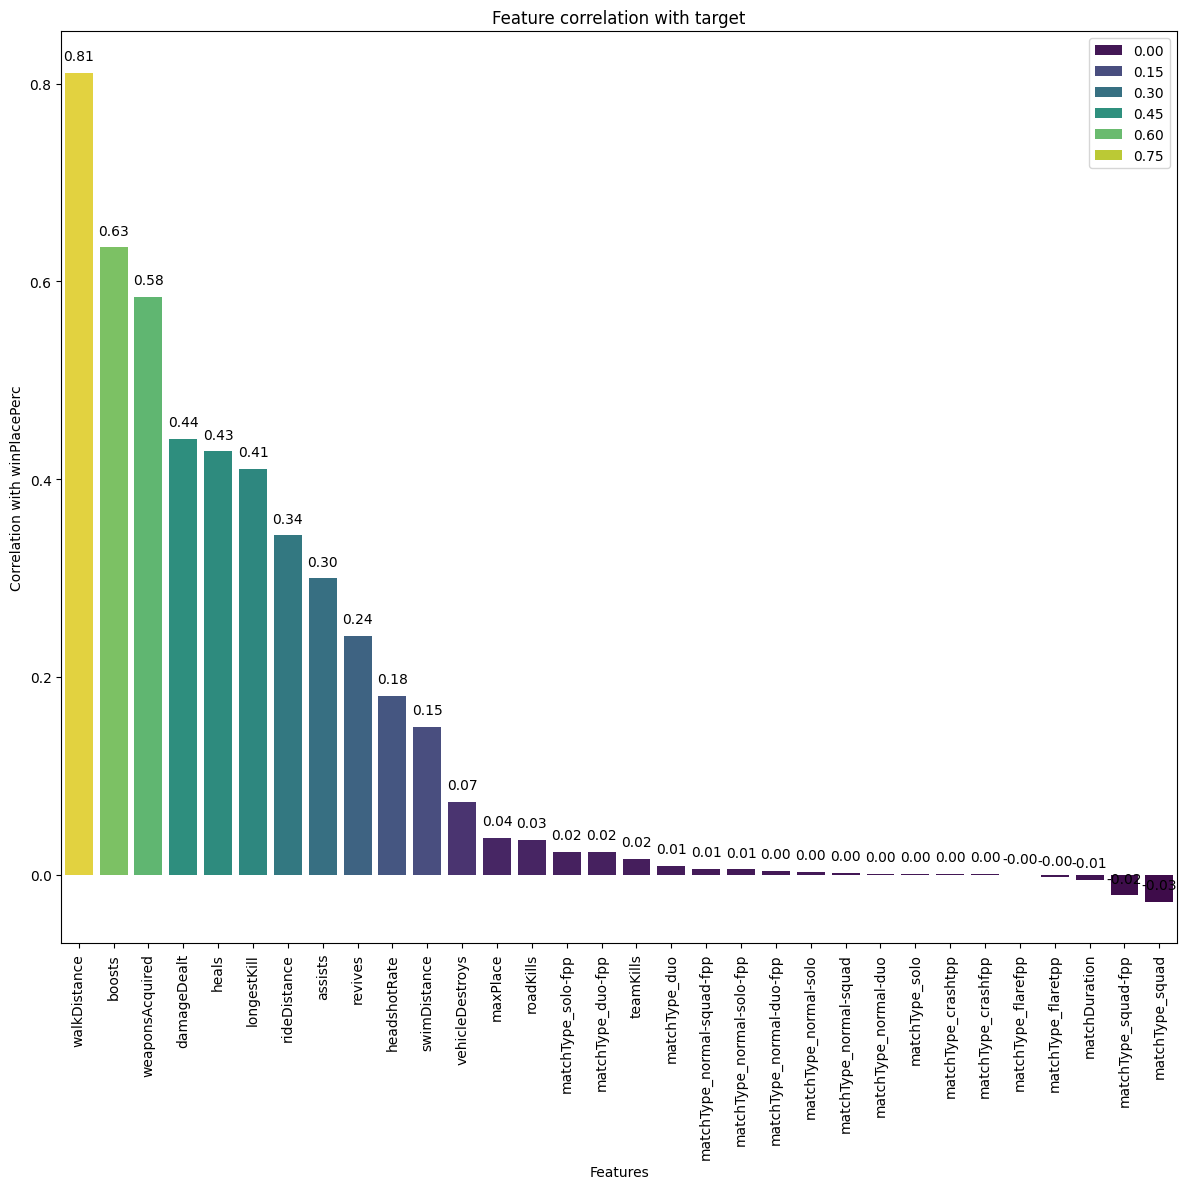

In [12]:
feature_corr = df_features.apply(lambda col: col.corr(df_target)).sort_values(ascending=False)
plt.figure(figsize=(12, 12))
sns.barplot(x=feature_corr.index, y=feature_corr.values, hue=feature_corr.values, palette='viridis')
plt.xticks(rotation=90)
for i, v in enumerate(feature_corr.values):
    plt.text(i, v + 0.01, f"{v:.2f}", ha='center', va='bottom')
plt.xlabel('Features')
plt.ylabel('Correlation with winPlacePerc')
plt.title('Feature correlation with target')
plt.tight_layout()
plt.show()

**First Clues: What Actions Correlate with Winning?**

This correlation heatmap gives us our first set of clues. It tells a simple, one-on-one story: how does each individual action relate to a player's final placement?

Unsurprisingly, actions that signify survival and active participation have the strongest positive correlation with `winPlacePerc`:
* **`walkDistance` (0.81):** The strongest signal. Moving more means you are surviving longer.
* **`boosts` (0.63):** Using healing items means you are actively engaged in the game and managing your health to survive.
* **`weaponsAcquired` (0.58):** Finding weapons is a fundamental part of being able to defend yourself and win.

This gives us our initial hypothesis: **the longer you survive and the more active you are, the better your final placement will be.** Now, let's see if our machine learning models agree.

## Modeling

With our data cleaned, engineered, and explored, we can now proceed to the modeling phase. The goal here is twofold: **prediction** and **inference**.

1.  **Prediction**: First, we aim to build a model that can accurately predict a player's final `winPlacePerc` based on their in-game actions. We'll use standard regression metrics like Mean Absolute Error (MAE) and R-squared (R²) to evaluate its performance.

2.  **Inference**: More importantly, we will use our model as a tool for analysis. By examining the model's predictions—especially its errors—we can develop the "Frustration Score" we set out to create.

Our experiment will involve two models: a simple baseline to establish a benchmark and a more complex model to capture nuanced patterns.

In [13]:
X_train, X_val, y_train, y_val = train_test_split(df_features, df_target, test_size=0.2, random_state=random_state)

We will apply `StandardScaler` to our data for this model, as it is sensitive to the scale of the features

In [14]:
# Standardize numerical features for Linear Regression
numerical_features = X_train.select_dtypes(include=np.number).columns.drop(X_train.filter(like='matchType').columns)
scaler = StandardScaler()
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_val[numerical_features] = scaler.transform(X_val[numerical_features])

### Before we jump in: What is Regression?

In machine learning, **regression** is a type of analysis used to predict a continuous outcome. It's like trying to find an equation that explain the relationships between the set of features and our target. For this project, our goal is to predict the `winPlacePerc`, which is a continuous value between 0.0 and 1.0.

The most fundamental type of regression is **Linear Regression**. Its goal is to find the best-fit line that comes as close as possible to all the data points. This line represents the linear relationship between the input features and the output target.

The mathematical formula for a linear regression model with multiple features is:

$$Y = \beta_0 + \beta_1X_1 + \beta_2X_2 + ... + \beta_nX_n + \epsilon$$

Where:
* **$Y$** is the **dependent variable**—the value we are trying to predict (e.g., `winPlacePerc`).
* **$X_1, X_2, ..., X_n$** are the **independent variables**—our features (e.g., `walkDistance`, `boosts`).
* **$\beta_0$** is the **intercept** (or bias), which is the baseline value of $Y$ when all features are zero.
* **$\beta_1, \beta_2, ..., \beta_n$** are the **coefficients** for each feature. These are the weights the model learns. A coefficient tells us how much $Y$ is expected to change for a one-unit increase in its corresponding feature, holding all other features constant.
* **$\epsilon$** is the **error term**, which represents the difference between the actual value and the predicted value.

The "learning" process for a linear regression model involves finding the optimal values for the coefficients ($\beta_0, \beta_1, ...$) that **minimize the sum of the squared errors** between the predicted values and the actual values in the training data. This is why our evaluation metric, Root Mean Squared Error (RMSE), is relevant.

### Experiment 1: The Baseline Model (Linear Regression)

A **Linear Regression** model serves as our simple, quick benchmark. Any advanced model we build must outperform this one to justify its increased complexity.

This model is a great starting point because it's fast and highly interpretable. We've also already handled the most significant multicollinearity, which is a key assumption for linear models to perform well.

In [15]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_val)

# Evaluate the baseline model
mae_lr = mean_absolute_error(y_val, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_val, y_pred_lr))
r2_lr = r2_score(y_val, y_pred_lr)

print("--- Linear Regression Baseline Performance ---")
print(f"Mean Absolute Error (MAE): {mae_lr:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_lr:.4f}")
print(f"R-squared (R²): {r2_lr:.4f}")

--- Linear Regression Baseline Performance ---
Mean Absolute Error (MAE): 0.1149
Root Mean Squared Error (RMSE): 0.1523
R-squared (R²): 0.7541


Let us plot a graph to see the linear model in action.

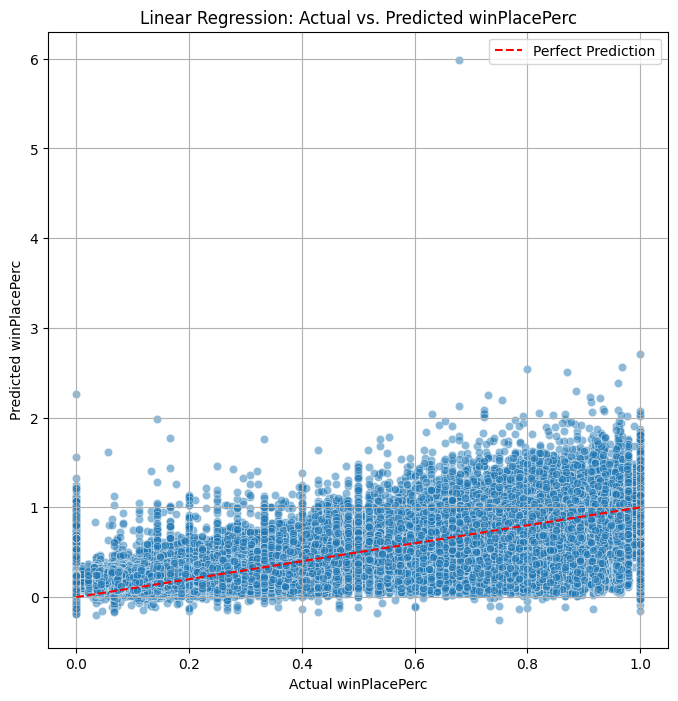

In [16]:
plt.figure(figsize=(8, 8))
sns.scatterplot(x=y_val, y=y_pred_lr, alpha=0.5)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Perfect Prediction')
plt.title('Linear Regression: Actual vs. Predicted winPlacePerc')
plt.xlabel('Actual winPlacePerc')
plt.ylabel('Predicted winPlacePerc')
plt.legend()
plt.grid(True)
plt.show()

Let's also retrieve the equation that the Linear Model generated so we can understand the priorities set by it. The equation is in the form of $$Y = \beta_0 + \beta_1X_1 + \beta_2X_2 + ... + \beta_nX_n$$ so let's just retrieve the coefficients for each. 

Intercept (β₀): 0.3884


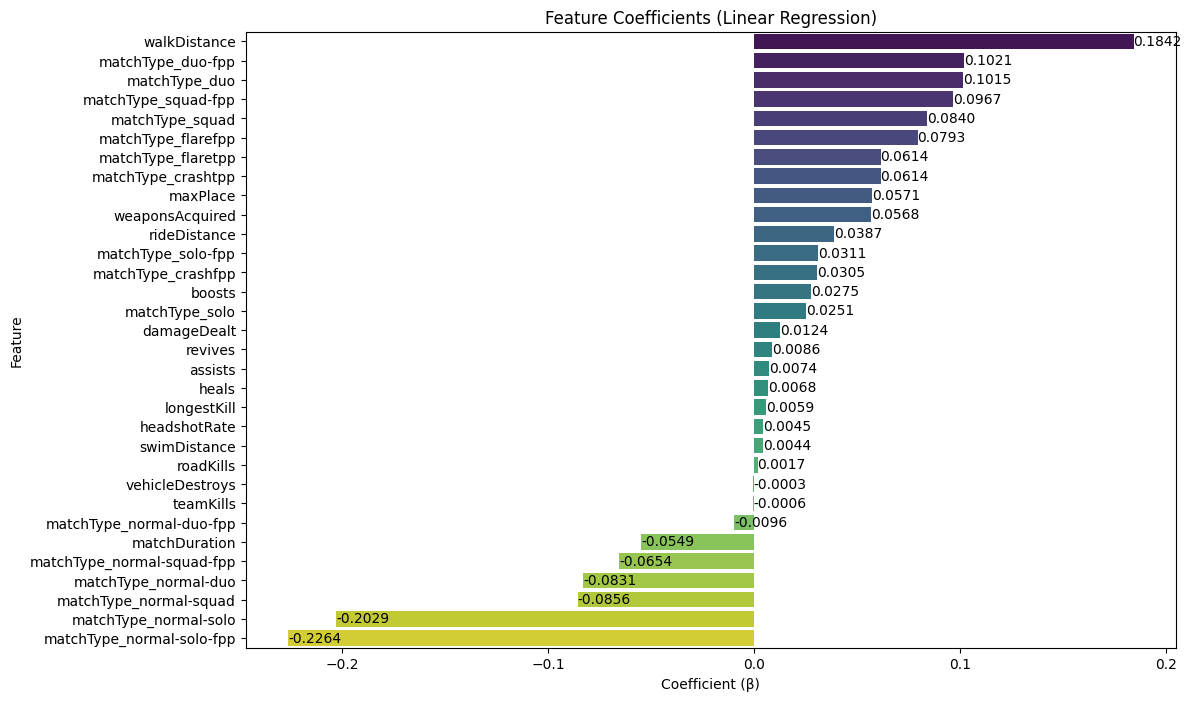

In [23]:
print(f"Intercept (β₀): {lr_model.intercept_:.4f}")

# Create a DataFrame of features and their coefficients
coeffs = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient (β)': lr_model.coef_
}).sort_values(by='Coefficient (β)', ascending=False)

# bar graph of feature coefficients
plt.figure(figsize=(12, 8))
sns.barplot(x='Coefficient (β)', y='Feature', data=coeffs, palette='viridis', hue='Feature')
for i, v in enumerate(coeffs['Coefficient (β)']):
    plt.text(v, i, f"{v:.4f}", va='center')
plt.title('Feature Coefficients (Linear Regression)')
plt.show()

### Experiment 2: The Advanced Model (Random Forest Regressor)

Next, we'll train a **Random Forest Regressor**, which captures complex, non-linear relationships that a linear model might miss. For instance, it might learn that using boosts is most effective only after a player has also dealt a certain amount of damage—an interaction a linear model can't easily see.

Because Random Forests are tree-based, they are not sensitive to the scale of features, but we will use our scaled data for consistency. This model will also provide a built-in feature importance ranking, which will be valuable for confirming or challenging the insights from our initial EDA.

In [18]:
# Note: RandomForestRegressor is a time and memory intensive model, so we limit the number of trees and depth for this example.
rf_model = RandomForestRegressor(random_state=random_state,
                                n_jobs=-1,
                                n_estimators=50,
                                max_depth=10,)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_val)

# Evaluate the baseline model
mae_rf = mean_absolute_error(y_val, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_val, y_pred_rf))
r2_rf = r2_score(y_val, y_pred_rf)

print("--- Random Forest Performance ---")
print(f"Mean Absolute Error (MAE): {mae_rf:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_rf:.4f}")
print(f"R-squared (R²): {r2_rf:.4f}")

--- Random Forest Performance ---
Mean Absolute Error (MAE): 0.0937
Root Mean Squared Error (RMSE): 0.1302
R-squared (R²): 0.8203


The RandomForestRegressor did noticeably better on all counts compared to the LinearRegressor. This is because the LinearRegressor learns the individual weight of each feature, while the RandomForestRegressor learns the combined, synergestic effects. 

c:\Users\dgane\miniconda3\envs\itcs-3162\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


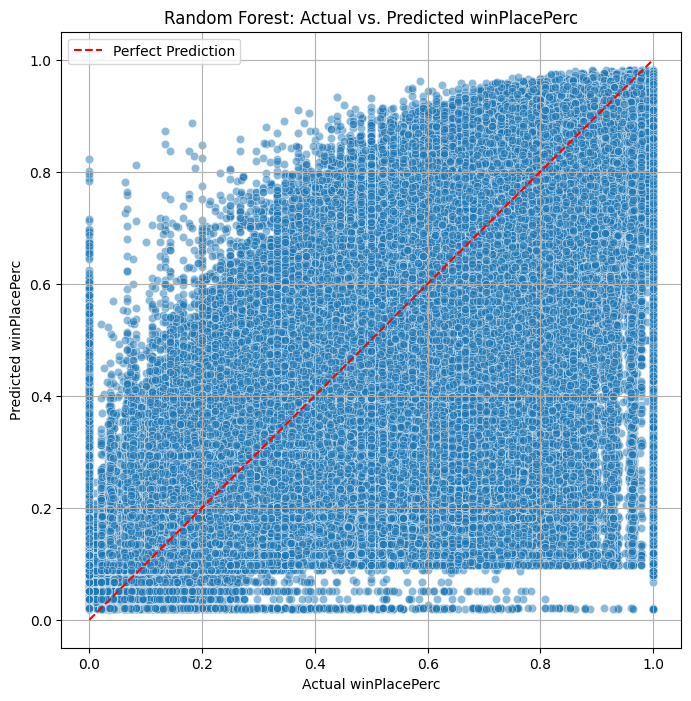

In [19]:
plt.figure(figsize=(8, 8))
sns.scatterplot(x=y_val, y=y_pred_rf, alpha=0.5)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Perfect Prediction')
plt.title('Random Forest: Actual vs. Predicted winPlacePerc')
plt.xlabel('Actual winPlacePerc')
plt.ylabel('Predicted winPlacePerc')
plt.legend()
plt.grid(True)
plt.show()

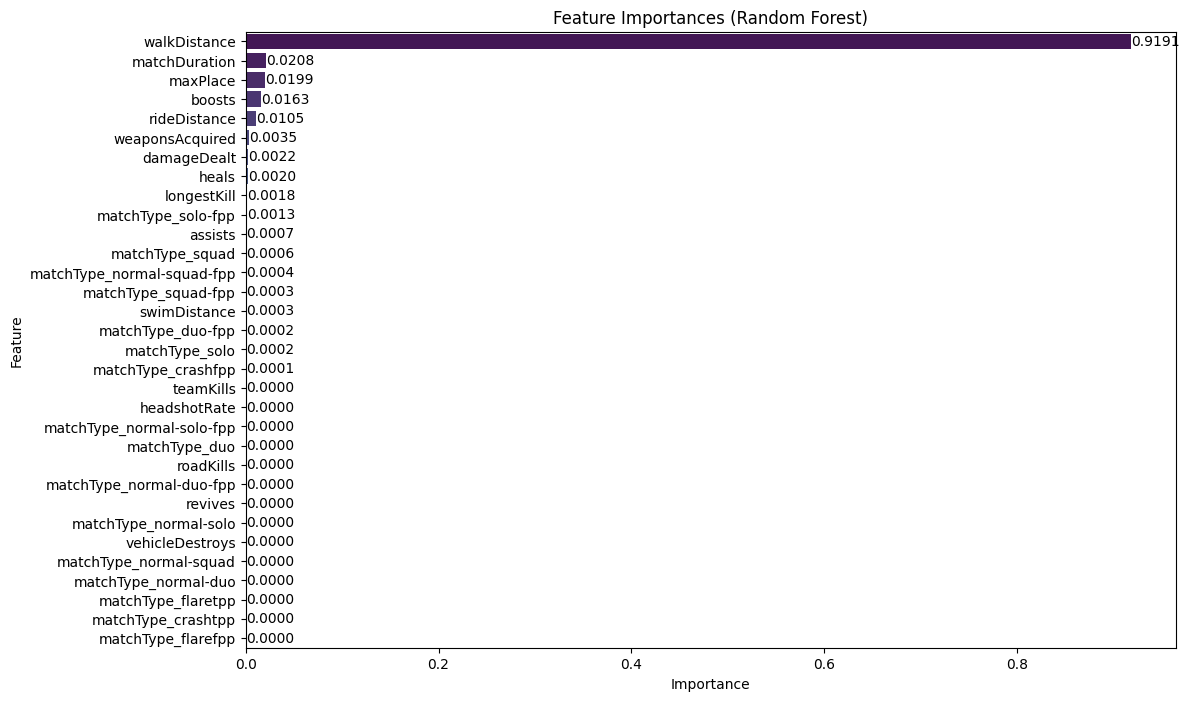

In [27]:
importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis', hue='Feature')
for i, v in enumerate(feature_importance_df['Importance']):
    plt.text(v, i, f"{v:.4f}", va='center')
plt.title('Feature Importances (Random Forest)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

## Finding the Frustration Score

Using our best-performing model (the Random Forest), we will extract the errors for insight. The error, or **residual**, is calculated for each player as:

`Residual = Actual winPlacePerc - Predicted winPlacePerc`

**How this works**: The model has used various metrics to predict what leads to a successful game and a higher ranking. Therefore, in the validation data, when the actual placement is much less than the predicted score, this can lead to high frustration. The larger the residual, the higher the frustration. This could lead to high customer churn. Our goal is to identify these players, their strategies, and how we can help them. 

A large negative residual indicates a **"High Frustration"** game. This means the model looked at the player's stats (high damage, lots of boosts, etc.) and predicted a high finish, but they were eliminated early. By isolating and analyzing these "frustrating" games, we can provide targeted advice on what causes well-performing players to fail unexpectedly.

In [21]:
predictions = rf_model.predict(X_val)
residuals = y_val - predictions # if its negative, the player's placement was worse than predicted

results_df = X_val.copy()
results_df['winPlacePerc_actual'] = y_val
results_df['winPlacePerc_predicted'] = predictions
results_df['frustration_score (residual)'] = residuals

# We'll define frustrating games as the games in the bottom 1st percentile of residuals
# (i.e., where the actual placement was much worse than predicted)
frustration_threshold = results_df['frustration_score (residual)'].quantile(0.01)
frustrating_games = results_df[results_df['frustration_score (residual)'] <= frustration_threshold]

print(f"Identified {len(frustrating_games)} highly frustrating games for analysis.\n")

# Now we will compare the stats of frustrated players vs. average players
# This will tell us what the frustrated players did differently!
comparison_df = pd.DataFrame({
    'Average Player (Validation Set)': X_val.mean(),
    'Frustrated Player': frustrating_games.mean()
})

# Display the most interesting columns for comparison
interesting_columns = ['damageDealt', 'heals', 'boosts', 'walkDistance', 'weaponsAcquired', 'longestKill']
print("--- Comparison of Player Stats ---")
print(comparison_df.loc[interesting_columns])

Identified 8894 highly frustrating games for analysis.

--- Comparison of Player Stats ---
                 Average Player (Validation Set)  Frustrated Player
damageDealt                            -0.002003           0.137435
heals                                  -0.000780           0.228554
boosts                                  0.000625           0.273661
walkDistance                           -0.001707           0.613246
weaponsAcquired                        -0.000484           0.569183
longestKill                            -0.000143           0.114056


In the table generated, we pick five interesting metrics, and compare the average performance of the general player to that of our selected frustrated players. The frustrated player is defined as scoring in the bottom 1% of the residual, meaning they are scoring far worse than what the model predicts. 

The results are significant. The frustrated player is not an underperformer but an overperformer who fails to secure a win.

* **Superior Survival and Looting:** Their `walkDistance` (+0.61) and `weaponsAcquired` (+0.57) scores are far above average, indicating they survive deep into the match.
* **Superior Combat and Resource Management:** They also outperform the average player in `damageDealt` (+0.14), `boosts` (+0.27), and `heals` (+0.23), proving they are both skilled in combat and good at managing their resources.

This statistical superiority is precisely why our model predicted a high finish for them. Their low actual placement, therefore, points to factors not captured in our data, such as poor late-game positioning or decision-making under pressure.

## Conclusion and Next Steps

Our Random Forest model successfully predicted player placement with a high degree of accuracy (82% R-squared) and, more importantly, allowed us to identify a key player segment: the "Frustrated Player." These are players who demonstrate superior skill in combat, looting, and survival but still fail to achieve a high rank.

This analysis moves beyond simple prediction to provide a diagnostic tool that can generate specific, data-driven advice.

**Advice for Players:** The player's in-game stats show that they are highly skilled players, so their failiure is not due to poor mechanics but likely due to late-game strategy. 
* Prioritize End-Game Positioning over Kills. To win, you not only need a high `damageDealt`, but also survive to the end. Therefore, the focus must shift from hunting or kills to securing a strong, defensible position inside the next zone. 
* Play the Zone, not just the Players. Players have a strong in-game `walkDistance`, equating to their survival. This is best used to rotate early into the center of the final circles. The player must be well-positioned and paitent. 
* Avoid Overconfidence. Overall, the data shows an excellent mid-game performance, but in a battle royale game, one small mess up is all it takes to lose. So it is important to not take any unnecessary risks late into the game. 


**Advice for Developers:** The frustration score identifies a high-skill, high-engagement player segment that is at risk of churning due to a negative play experience. To improve retention, you can: 
* Implement a Performance Score in the Post-Match Report. The final rank is clearly not fully indicative of in-game performance, so a model similar to ours can be used to communicate the bigger picture to the players. 
* Create a Tactical Replay feature. For players with a high frustration score, a brief replay can be offered that highlights the pivotal reason for their loss. An AI model can be trained to evaluate their game and record which move in particular needs to be worked on, if any (similar to how chess moves are ranked as 'Poor', 'Brilliant', etc in that context.)
* Award a Performance Bonus to Rank Points. This can soften the blow of a frustrating loss by awarding a small amount of bonus RP to players whose performance was statistically much better than their placement. 

## Limitations

While our model and the frustration score provide valuable insights, it's important to acknowledge the limitations of our analysis. These are areas where more data or different techniques could lead to an even deeper understanding.

* **Lack of Contextual and Temporal Data**: This dataset mainly focused on post-match summaries, meaning we don't have information on positional data or a timeline of events. Therefore our previous idea of the frustrated player having late-game issues is more of an educated guess because we don't have a way to properly validate that. 
* **Subjectivity in Feature Selction**: When we handled feature removal due to multicollinearity, we had to make choices about which features to remove. This may still be subject to bias, so any analyst reading this is encouraged to go back and experiment with the features removed to see if they make any significant difference. 
* **Cmputational Constraints**: The PUBG dataset is massive, with over 4 million rows. To train our Random Forest model in a reasonable amount of time, we had to limit its complexity. A more powerful computer could have trained a deeper, more complex model on the full dataset without these constraints. Future analysts are encouraged to explore different models with different hyperparameter tuning on their own time. 
* **The frustration score is an abstraction**: We defined a frustrated player as someone in the bottom 1% of residuals. This is a great analytical tool but remains an abstraction. There may be players within our frustrated subset who may have not cared, and there may be players outside our subset whom we may have missed. More analysis could be used to capture these groups and ensure a favorable experience for all. 

## Impact

While this project is focused on a gaming dataset, the implications of predictive modeling and performance analysis extend into the real world, with both positive and potentially negative impacts.

**Positive Impacts:** 
- **Enhanced Player Experience & Retention:** The frustration score is a tool designed to identify and help players who are skilled but not seeing results. By providing targeted, data-driven feedback, a game developer could create in-game tutorials or post-match reports that help players improve. This leads to a more rewarding experience, reduces player churn, and builds a healthier, more engaged community.
- **Improved Game Balance:** By understanding which behaviors are most predictive of winning, developers can analyze if the game is balanced. For instance, if `rideDistance` had a massive negative correlation, it might indicate that vehicles are too risky or underpowered. This analysis can inform future game updates to ensure multiple playstyles are viable.

**Negative Impacts:**
- **Over-Optimization and "Gaming the System":** If players become aware of the most heavily weighted features (like `walkDistance`), it could lead to "meta-gaming" where players focus on maximizing those stats rather than playing the game organically. This could result in boring or passive gameplay, as players might choose to run in circles at the edge of the map instead of engaging in combat.
- **Bias and Fairness:** Our model might inadvertently favor one playstyle (e.g., the slow, strategic "Survivor") over another (e.g., the aggressive "Rusher"). This could lead to a ranking system that unfairly penalizes players who have a different but equally valid approach to winning. If this model were used to adjust ranked points, it would need to be carefully validated to ensure it doesn't create a biased ecosystem.
- **Data Privacy:** This analysis relies on collecting vast amounts of player data. While the data is anonymized, it highlights the broader ethical responsibility of companies to be transparent about what data they collect and how it is used, even for internal analytics.